## SPACE-GM Tutorial

This tutorial demonstrates the workflow of SPACE-GM, which contains the following steps:

1. Construct cellular graphs with raw inputs
2. Construct `CellularGraphDataset` and attach node-level / graph-level tasks
3. Initialize a Graph Neural Network (GNN) according to the prediction tasks
4. Train the GNN by randomly sampling subgraphs
5. Evaluate the GNN on node-level / graph-level tasks

In [2]:
import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Found existing installation: torch-geometric 2.3.1
Uninstalling torch-geometric-2.3.1:
  Successfully uninstalled torch-geometric-2.3.1
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu117.html
  Using cached https://data.pyg.org/whl/torch-2.0.0%2Bcu117/torch_scatter-2.1.1%2Bpt20cu117-cp310-cp310-linux_x86_64.whl (10.2 MB)
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu117.html
  Using cached https://data.pyg.org/whl/torch-2.0.0%2Bcu117/torch_sparse-0.6.17%2Bpt20cu117-cp310-cp310-linux_x86_64.whl (4.8 MB)
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu117.html
  Using cached https://data.pyg.org/whl/torch-2.0.0%2Bcu117/torch_cluster-1.6.1%2Bpt20cu117-cp310-cp310-linux_x86_64.whl (3.3 MB)
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-nd963ynt
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-nd963ynt
  Resolved https://github.com/pyg-team/pytorch_geom

In [4]:
import torch

torch.cuda.is_available()

False

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import spacegm

------------
### Step 1: Construct Cellular Graphs

We first construct cellular graphs as `networkx.Graph` using raw inputs including cell coordinates, cell types, biomarker expression, etc.

Raw files are assumed to be sorted in regions, each region should contain a spatially-continuous area of tissue and has all cells in the area identified and segmented.

For each region, we consider the following raw inputs:
- Cell coordinates stored in a csv file:
    - This file should contain at least two columns `X` and `Y` representing the 2D coordinates of cell centroids.
    - We highly recommend adding another column `CELL_ID` to match the rows with other raw inputs.
    - Example:
    | CELL_ID | X | Y |
    | --- | --- | --- |
    | 0 | 3 | 10 |
    | 1 | 25 | 12 |
    | 2 | 16 | 30 |
    | 3 | 32 | 26 |

- (Optional) Cell types stored in a csv file:
    - This file should contain at least one column other than `CELL_ID`, in which case this column will be treated as the cell type column. Otherwise, please explicitly name the cell type column as `CELL_TYPE`.
    - Example:
    | CELL_ID | CELL_TYPE |
    | --- | --- |
    | 0 | CD4 T cell |
    | 1 | CD8 T cell |
    | 2 | Tumor cell |
    | 3 | B cell |

- (Optional) Cell biomarker expression stored in a csv file:
    - This file should contain at least one column other than `CELL_ID`. All numeric columns in this file (other than `CELL_ID`) will be treated as biomarkers
    - Example (note that column `REGION_ID` will not be considered as a biomarker in this example):
    | CELL_ID | REGION_ID | BIOMARKER1 | BIOMARKER 2|
    | --- | --- | --- | --- |
    | 0 | region1 | 0.5 | 1.1 |
    | 1 | region1 | 0.8 | 2.3 |
    | 2 | region1 | 1.5 | 0.9 |
    | 3 | region1 | 5.5 | 0.1 |

- (Optional) Additional cell features stored in a csv file:
    - This file should contain at least one column other than `CELL_ID`. All numeric columns in this file (other than `CELL_ID`) will be treated as additional features for the cells
    - Example (column `SIZE` will be added as additional node attributes to the cellular graph):
    | CELL_ID | SIZE |
    | --- | --- |
    | 0 | 0.2 |
    | 1 | 0.5 |
    | 2 | 0.8 |
    | 3 | 0.1 |

- (Optional) Coordinates for the cell voronoi polygons:
    - Stored in a `json` or a `pickle` file. This file should contain a list of voronoi polygons enclosing cells.
    - Note that voronoi polygons can be calculated on-the-fly based on cell coordinates.
    - Example of content:
        ```text
        [array([[22.5, 22. ],
                [32.3, 17.1],
                [32.3, 12.5],
                [32.3, 0.  ],
                [18.8, 0.  ],
                [15.,  0.  ],
                [13.4, 17.5],
                [22.5, 22. ]]),
         array([[ 0. , 28.9],
                [ 0. , 30.3],
                [ 7.8, 30.3],
                [24.6, 30.3],
                [22.5, 22. ],
                [13.4, 17.5],
                [ 0. , 26.2],
                [ 0. , 28.9]]),
         array([[ 0. , 26.2],
                [13.4, 17.5],
                [15. ,  0. ],
                [12.3,  0. ],
                [ 0. ,  0. ],
                [ 0. , 18.8],
                [ 0. , 26.2]]),
         array([[24.6, 30.3],
                [28.2, 30.3],
                [32.3, 30.3],
                [32.3, 25.1],
                [32.3, 17.1],
                [22.5, 22. ],
                [24.6, 30.3]])]
        ```

Additionally, to train models for graph-level (region-level) tasks, a separate csv file is required to provide the labels:
- Labels for graph-level tasks:
    - The first column of this file must be `REGION_ID`: identifiers for regions in the dataset. This column will be used as the index for graph labels stored in `spacegm.inference.AddGraphLabel`.
    - The following columns store labels for graph-level tasks, with task names as column names.
    - Example:

    | REGION_ID | GRAPH_TASK1 | GRAPH_TASK 2|
    | --- | --- | --- |
    | region 1 | 0 | 1 |
    | region 2 | 0 | 0 |
    | region 3 | 1 | 1 |

<br/><br/><br/><br/>
We provided some example files under `data/voronoi`:

In [2]:
from spacegm.graph_build import load_cell_coords, load_cell_types, load_cell_biomarker_expression, load_cell_features
region_id = "BaselTMA_SP41_2_X2Y8"
cell_coords_file = '/juno/work/shah/users/ibrahih3/codebase/space-gm/data_bodenmiller/basel_data/BaselTMA_SP41_2_X2Y8_coords.csv'
cell_types_file = '/juno/work/shah/users/ibrahih3/codebase/space-gm/data_bodenmiller/basel_data/BaselTMA_SP41_2_X2Y8_cell_types.csv'
cell_biomarker_expression_file = '/juno/work/shah/users/ibrahih3/codebase/space-gm/data_bodenmiller/basel_data/BaselTMA_SP41_2_X2Y8_expression.csv'
# cell_features_file = 'data/voronoi/UPMC_c001_v001_r001_reg001.cell_features.csv'

graph_label_file = '/juno/work/shah/users/ibrahih3/codebase/space-gm/data_bodenmiller_label/basel_label.csv'

print("\nInputs for region %s:" % region_id)
print("\nCell coordinates")
display(load_cell_coords(cell_coords_file))
print("\nCell types")
display(load_cell_types(cell_types_file))
print("\nCell biomarker expression")
display(load_cell_biomarker_expression(cell_biomarker_expression_file))
# print("\nAdditional cell features")
# display(load_cell_features(cell_features_file))

print("\nGraph-level tasks")
display(pd.read_csv(graph_label_file))


Inputs for region BaselTMA_SP41_2_X2Y8:

Cell coordinates


,CELL_ID,X,Y
0,BaselTMA_SP41_2_X2Y8_1,34.814516,3.814516
1,BaselTMA_SP41_2_X2Y8_2,46.800000,2.842857
2,BaselTMA_SP41_2_X2Y8_3,55.608696,1.521739
3,BaselTMA_SP41_2_X2Y8_4,66.763158,2.250000
4,BaselTMA_SP41_2_X2Y8_5,179.736842,1.157895
...,...,...,...
2683,BaselTMA_SP41_2_X2Y8_2684,438.000000,767.085714
2684,BaselTMA_SP41_2_X2Y8_2685,447.068182,767.318182
2685,BaselTMA_SP41_2_X2Y8_2686,459.283019,767.245283
2686,BaselTMA_SP41_2_X2Y8_2687,532.046296,765.148148



Cell types


,CELL_ID,CELL_TYPE
0,BaselTMA_SP41_2_X2Y8_1,CK+ HR lo
1,BaselTMA_SP41_2_X2Y8_2,CK+ HR lo
2,BaselTMA_SP41_2_X2Y8_3,CK7+
3,BaselTMA_SP41_2_X2Y8_4,CK+ HR hi
4,BaselTMA_SP41_2_X2Y8_5,CK+ HR hi
...,...,...
2683,BaselTMA_SP41_2_X2Y8_2684,Endothelial
2684,BaselTMA_SP41_2_X2Y8_2685,Vimentin hi
2685,BaselTMA_SP41_2_X2Y8_2686,CK+ HR hi
2686,BaselTMA_SP41_2_X2Y8_2687,CK+ HR+



Cell biomarker expression


,CELL_ID,BM-1021522TM169DI EGFR,BM-117792DY163DI GATA3,BM-1261726IN113DI HISTONE,BM-1441101ER168DI KI67,BM-174864ND148DI SMA,BM-1921755SM149DI VIMENTI,BM-198883YB176DI CLEAVED,BM-201487EU151DI CERBB,BM-207736TB159DI P53,...,BM-6967GD160DI CD44,BM-71790DY162DI CD45,BM-77877ND146DI CD68,BM-8001752SM152DI CD3EPSI,BM-92964ER166DI CARBONI,BM-971099ND144DI CYTOKER,BM-98922YB174DI CYTOKER,BM-ND145DI TWIST,BM-PHOSPHO MTOR,BM-PHOSPHO S6
0,BaselTMA_SP41_2_X2Y8_1,0.246217,0.385657,4.620242,0.080534,0.099028,0.084540,1.016459,1.602201,0.036526,...,5.351835,0.073959,0.534661,0.000000,0.494848,0.617752,0.051974,0.406908,0.746158,0.427113
1,BaselTMA_SP41_2_X2Y8_10,0.355899,0.039103,7.203313,0.022683,0.328517,3.850891,0.451956,0.599551,0.037353,...,18.080585,0.035301,0.103042,0.010435,0.261704,0.035092,0.000000,0.107628,0.607560,0.917712
2,BaselTMA_SP41_2_X2Y8_100,0.332683,0.006803,8.653177,0.014743,0.426861,5.145165,0.451341,0.525175,0.021068,...,9.155012,0.091750,0.188676,0.035368,0.496233,0.082056,0.000000,0.186201,0.661436,0.406300
3,BaselTMA_SP41_2_X2Y8_1000,0.306576,0.125733,6.047886,0.090263,0.802009,1.513507,0.693687,1.421491,0.130187,...,21.663901,0.993787,0.228537,0.267576,0.457409,0.280291,0.049947,2.689871,0.769658,0.727629
4,BaselTMA_SP41_2_X2Y8_1001,0.570942,0.113852,7.813009,0.071429,3.664236,2.949356,0.598908,0.486456,0.038439,...,27.481128,0.441841,0.154712,0.200849,0.463762,0.075942,0.005442,0.199809,0.599025,0.166035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2683,BaselTMA_SP41_2_X2Y8_995,0.280632,0.210497,14.610496,1.237852,1.021958,2.538814,0.670556,1.065553,0.057685,...,46.179947,0.556959,0.425306,0.088456,0.305423,0.128076,0.010914,0.180192,0.590137,0.397986
2684,BaselTMA_SP41_2_X2Y8_996,0.137099,0.019373,6.780269,0.013373,0.712721,1.340226,0.212174,0.084320,0.068713,...,4.214022,0.060613,0.089423,0.000000,0.140792,0.032759,0.056099,0.134478,0.330909,0.249001
2685,BaselTMA_SP41_2_X2Y8_997,0.213335,0.077619,14.117228,0.000000,1.635555,2.895962,0.486355,0.208841,0.057055,...,14.611616,0.060583,0.119439,0.123482,0.351106,0.128571,0.040603,0.175851,0.762056,0.357209
2686,BaselTMA_SP41_2_X2Y8_998,0.464506,0.110801,14.123553,0.017057,3.209292,4.048957,0.917088,0.686612,0.056754,...,22.893760,0.308942,0.644189,0.061968,0.698867,0.084409,0.009892,0.506255,0.943329,1.737051



Graph-level tasks


,REGION_ID,ERStatus,PRStatus,HER2Status,HR_status
0,BaselTMA_SP41_257_X3Y1,1,0,0,ERposPRnegHER2neg
1,BaselTMA_SP41_7_X5Y1,1,1,0,ERposPRposHER2neg
2,BaselTMA_SP41_166_X15Y4,0,0,0,ERnegPRnegHER2neg
3,BaselTMA_SP41_238_X7Y1,1,1,0,ERposPRposHER2neg
4,BaselTMA_SP41_68_X9Y1,1,1,0,ERposPRposHER2neg
...,...,...,...,...,...
278,BaselTMA_SP43_225_X2Y9,1,1,0,ERposPRposHER2neg
279,BaselTMA_SP43_226_X6Y9,1,0,0,ERposPRnegHER2neg
280,BaselTMA_SP43_245_X6Y5,1,1,0,ERposPRposHER2neg
281,BaselTMA_SP43_269_X5Y9,1,1,0,ERposPRposHER2neg


<br/><br/><br/><br/>

A networkx graph can be constructed using the inputs above

In [8]:
print("Constructing nx graph for region %s" % region_id)
G = spacegm.construct_graph_for_region(
    region_id,
    cell_coords_file=cell_coords_file,
    cell_types_file=cell_types_file,
    cell_biomarker_expression_file=cell_biomarker_expression_file)
    # cell_features_file=cell_features_file)
print(G)

print("Information stored in a node:")
print(G.nodes[0])

Constructing nx graph for region BaselTMA_SP41_2_X2Y8
Graph with 2688 nodes and 7874 edges
Information stored in a node:
{'voronoi_polygon': array([[  6.21149299, 438.40814099],
       [ 11.81015654, 429.8764212 ],
       [  0.        , 430.25984413],
       [  0.        , 438.05513384],
       [  6.21149299, 438.40814099]]), 'cell_id': 'BaselTMA_SP41_2_X2Y8_1490', 'center_coord': (3.27586206896552, 434.655172413793), 'cell_type': 'Vimentin hi', 'biomarker_expression': {'1021522TM169DI EGFR': 0.442961620883715, '117792DY163DI GATA3': 0.42516219935329, '1261726IN113DI HISTONE': 19.293078485115, '1441101ER168DI KI67': 0.0, '174864ND148DI SMA': 1.61484886882217, '1921755SM149DI VIMENTI': 2.2936378789186, '198883YB176DI CLEAVED': 0.848307719924058, '201487EU151DI CERBB': 0.997474139897869, '207736TB159DI P53': 0.0686743879685349, '234832LU175DI PANCYTO': 11.0726238715818, '3111576ND143DI CYTOKER': 0.411880645111809, '312878GD158DI PROGEST': 0.898769946880269, '322787ND150DI CMYC': 0.162154

<br/><br/><br/><br/>
Then we process all four regions from the example files and store the nx graphs into a dataset folder

In [3]:
raw_data_root = "/juno/work/shah/users/ibrahih3/codebase/space-gm/data_bodenmiller/basel_data"

dataset_root = "/juno/work/shah/users/ibrahih3/codebase/space-gm/example_data_bodenmiller"
nx_graph_root = os.path.join(dataset_root, "graph")
fig_save_root = os.path.join(dataset_root, "fig")
model_save_root = os.path.join(dataset_root, 'model')

os.makedirs(nx_graph_root, exist_ok=True)
os.makedirs(fig_save_root, exist_ok=True)
os.makedirs(model_save_root, exist_ok=True)

# region_ids = [
#     'UPMC_c001_v001_r001_reg001',
#     'UPMC_c001_v001_r001_reg004',
#     'UPMC_c001_v001_r001_reg009',
#     'UPMC_c001_v001_r001_reg014',
# ]

region_ids = ['BaselTMA_SP41_257_X3Y1',
 'BaselTMA_SP41_7_X5Y1',
 'BaselTMA_SP41_166_X15Y4',
 'BaselTMA_SP41_238_X7Y1',
 'BaselTMA_SP41_68_X9Y1',
 'BaselTMA_SP41_72_X11Y1',
 'BaselTMA_SP41_274_X13Y1',
 'BaselTMA_SP41_153_X7Y5',
 'BaselTMA_SP41_58_X15Y1',
 'BaselTMA_SP41_206_X1Y2',
 'BaselTMA_SP41_135_X8Y5',
 'BaselTMA_SP41_280_X9Y5',
 'BaselTMA_SP41_220_X10Y5',
 'BaselTMA_SP41_88_X11Y5_235',
 'BaselTMA_SP41_88_X11Y5_242',
 'BaselTMA_SP41_24_X5Y2',
 'BaselTMA_SP41_284_X7Y2',
 'BaselTMA_SP41_20_X12Y5',
 'BaselTMA_SP41_18_X13Y5',
 'BaselTMA_SP41_42_X14Y5',
 'BaselTMA_SP41_52_X9Y3',
 'BaselTMA_SP41_141_X11Y2',
 'BaselTMA_SP41_83_X13Y2',
 'BaselTMA_SP41_100_X15Y5',
 'BaselTMA_SP41_204_X16Y4_237',
 'BaselTMA_SP41_204_X16Y4_238',
 'BaselTMA_SP41_177_X16Y5',
 'BaselTMA_SP41_31_X15Y2',
 'BaselTMA_SP41_216_X1Y6',
 'BaselTMA_SP41_283_X2Y6',
 'BaselTMA_SP41_282_X1Y3',
 'BaselTMA_SP41_45_X3Y3',
 'BaselTMA_SP41_133_X3Y6',
 'BaselTMA_SP41_211_X4Y6',
 'BaselTMA_SP41_228_X7Y3',
 'BaselTMA_SP41_239_X11Y3_151',
 'BaselTMA_SP41_239_X11Y3_165',
 'BaselTMA_SP41_117_X13Y3',
 'BaselTMA_SP41_165_X5Y6',
 'BaselTMA_SP41_231_X6Y6_10',
 'BaselTMA_SP41_231_X6Y6_256',
 'BaselTMA_SP41_37_X7Y6',
 'BaselTMA_SP41_57_X8Y6',
 'BaselTMA_SP41_227_X9Y6',
 'BaselTMA_SP41_234_X10Y6',
 'BaselTMA_SP41_254_X11Y6',
 'BaselTMA_SP41_277_X12Y6',
 'BaselTMA_SP41_86_X15Y3',
 'BaselTMA_SP41_247_X13Y6',
 'BaselTMA_SP41_33_X14Y6',
 'BaselTMA_SP41_214_X15Y6',
 'BaselTMA_SP41_237_X16Y6',
 'BaselTMA_SP41_263_X1Y4',
 'BaselTMA_SP41_39_X1Y7',
 'BaselTMA_SP41_61_X3Y4',
 'BaselTMA_SP41_44_X2Y7',
 'BaselTMA_SP41_186_X5Y4',
 'BaselTMA_SP41_224_X3Y7',
 'BaselTMA_SP41_104_X7Y4',
 'BaselTMA_SP41_218_X9Y4_185',
 'BaselTMA_SP41_218_X9Y4_240',
 'BaselTMA_SP41_159_X11Y4',
 'BaselTMA_SP41_159_X12Y4',
 'BaselTMA_SP41_38_X4Y7',
 'BaselTMA_SP41_114_X13Y4',
 'BaselTMA_SP41_196_X5Y7',
 'BaselTMA_SP41_268_X6Y7',
 'BaselTMA_SP41_62_X7Y7',
 'BaselTMA_SP41_219_X8Y7',
 'BaselTMA_SP41_256_X9Y7',
 'BaselTMA_SP41_55_X10Y7',
 'BaselTMA_SP41_60_X11Y7',
 'BaselTMA_SP41_92_X12Y7',
 'BaselTMA_SP41_11_X13Y7',
 'BaselTMA_SP41_126_X14Y7',
 'BaselTMA_SP41_191_X15Y7',
 'BaselTMA_SP41_40_X16Y7',
 'BaselTMA_SP41_14_X1Y8',
 'BaselTMA_SP41_2_X2Y8',
 'BaselTMA_SP41_134_X3Y8',
 'BaselTMA_SP41_112_X5Y8',
 'BaselTMA_SP41_53_X6Y8',
 'BaselTMA_SP41_129_X7Y8',
 'BaselTMA_SP41_203_X8Y8',
 'BaselTMA_SP41_276_X9Y8',
 'BaselTMA_SP41_101_X10Y8',
 'BaselTMA_SP41_41_X11Y8',
 'BaselTMA_SP41_255_X12Y8',
 'BaselTMA_SP41_267_X13Y8',
 'BaselTMA_SP41_48_X14Y8',
 'BaselTMA_SP41_212_X1Y9',
 'BaselTMA_SP41_106_X2Y9',
 'BaselTMA_SP41_63_X4Y9',
 'BaselTMA_SP41_8_X5Y9',
 'BaselTMA_SP41_9_X6Y9',
 'BaselTMA_SP42_13_X5Y8',
 'BaselTMA_SP42_215_X3Y1',
 'BaselTMA_SP42_36_X5Y1',
 'BaselTMA_SP42_113_X2Y5',
 'BaselTMA_SP42_84_X7Y1',
 'BaselTMA_SP42_105_X9Y1',
 'BaselTMA_SP42_6_X11Y1',
 'BaselTMA_SP42_156_X15Y1',
 'BaselTMA_SP42_51_X1Y2',
 'BaselTMA_SP42_25_X3Y2',
 'BaselTMA_SP42_120_X5Y2',
 'BaselTMA_SP42_29_X7Y2',
 'BaselTMA_SP42_240_X9Y2',
 'BaselTMA_SP42_28_X11Y2',
 'BaselTMA_SP42_253_X13Y2',
 'BaselTMA_SP42_251_X15Y2',
 'BaselTMA_SP42_217_X1Y3',
 'BaselTMA_SP42_80_X3Y3',
 'BaselTMA_SP42_70_X5Y3',
 'BaselTMA_SP42_96_X9Y3',
 'BaselTMA_SP42_10_X1Y5',
 'BaselTMA_SP42_35_X16Y4',
 'BaselTMA_SP42_138_X3Y5',
 'BaselTMA_SP42_264_X14Y5',
 'BaselTMA_SP42_160_X13Y5',
 'BaselTMA_SP42_54_X12Y5',
 'BaselTMA_SP42_98_X11Y5',
 'BaselTMA_SP42_91_X11Y3',
 'BaselTMA_SP42_161_X13Y3',
 'BaselTMA_SP42_188_X10Y5',
 'BaselTMA_SP42_74_X15Y3',
 'BaselTMA_SP42_190_X9Y5',
 'BaselTMA_SP42_192_X8Y5',
 'BaselTMA_SP42_185_X7Y5',
 'BaselTMA_SP42_145_X1Y4',
 'BaselTMA_SP42_181_X6Y5',
 'BaselTMA_SP42_16_X3Y4',
 'BaselTMA_SP42_189_X5Y5',
 'BaselTMA_SP42_210_X4Y5',
 'BaselTMA_SP42_275_X5Y4',
 'BaselTMA_SP42_154_X7Y4',
 'BaselTMA_SP42_89_X4Y6',
 'BaselTMA_SP42_183_X3Y6',
 'BaselTMA_SP42_56_X2Y6',
 'BaselTMA_SP42_130_X1Y6',
 'BaselTMA_SP42_136_X9Y4',
 'BaselTMA_SP42_175_X15Y5_235',
 'BaselTMA_SP42_175_X15Y5_236',
 'BaselTMA_SP42_76_X13Y6',
 'BaselTMA_SP42_158_X12Y6',
 'BaselTMA_SP42_261_X11Y6',
 'BaselTMA_SP42_109_X10Y6',
 'BaselTMA_SP42_174_X9Y6',
 'BaselTMA_SP42_123_X8Y6',
 'BaselTMA_SP42_64_X13Y4',
 'BaselTMA_SP42_232_X7Y6',
 'BaselTMA_SP42_27_X6Y6',
 'BaselTMA_SP42_148_X5Y6',
 'BaselTMA_SP42_81_X11Y4',
 'BaselTMA_SP42_279_X14Y6',
 'BaselTMA_SP42_152_X15Y6',
 'BaselTMA_SP42_146_X16Y6',
 'BaselTMA_SP42_229_X1Y7',
 'BaselTMA_SP42_171_X2Y7',
 'BaselTMA_SP42_176_X3Y7',
 'BaselTMA_SP42_99_X5Y7',
 'BaselTMA_SP42_258_X4Y7',
 'BaselTMA_SP42_273_X6Y7',
 'BaselTMA_SP42_285_X7Y7',
 'BaselTMA_SP42_5_X8Y7',
 'BaselTMA_SP42_223_X9Y7',
 'BaselTMA_SP42_46_X10Y7',
 'BaselTMA_SP42_236_X11Y7',
 'BaselTMA_SP42_73_X12Y7',
 'BaselTMA_SP42_178_X13Y7',
 'BaselTMA_SP42_151_X14Y7',
 'BaselTMA_SP42_208_X15Y7',
 'BaselTMA_SP42_182_X1Y8',
 'BaselTMA_SP42_127_X2Y8',
 'BaselTMA_SP42_169_X3Y8',
 'BaselTMA_SP42_184_X6Y8',
 'BaselTMA_SP42_198_X7Y8',
 'BaselTMA_SP42_71_X8Y8',
 'BaselTMA_SP42_164_X9Y8',
 'BaselTMA_SP42_262_X10Y8',
 'BaselTMA_SP42_121_X11Y8',
 'BaselTMA_SP42_12_X12Y8',
 'BaselTMA_SP42_179_X13Y8',
 'BaselTMA_SP42_167_X14Y8',
 'BaselTMA_SP42_163_X1Y9',
 'BaselTMA_SP42_82_X2Y9',
 'BaselTMA_SP42_59_X3Y9',
 'BaselTMA_SP42_155_X4Y9',
 'BaselTMA_SP42_162_X16Y7',
 'BaselTMA_SP43_87_X15Y4',
 'BaselTMA_SP43_142_X5Y1',
 'BaselTMA_SP43_1_X1Y8',
 'BaselTMA_SP43_128_X16Y7',
 'BaselTMA_SP43_17_X11Y4',
 'BaselTMA_SP43_102_X1Y4',
 'BaselTMA_SP43_173_X2Y8',
 'BaselTMA_SP43_79_X7Y4',
 'BaselTMA_SP43_271_X11Y8',
 'BaselTMA_SP43_131_X13Y4',
 'BaselTMA_SP43_143_X1Y2',
 'BaselTMA_SP43_233_X13Y7',
 'BaselTMA_SP43_243_X13Y3',
 'BaselTMA_SP43_278_X3Y2',
 'BaselTMA_SP43_132_X13Y1',
 'BaselTMA_SP43_34_X12Y5',
 'BaselTMA_SP43_144_X15Y1',
 'BaselTMA_SP43_124_X10Y8',
 'BaselTMA_SP43_180_X5Y2',
 'BaselTMA_SP43_222_X7Y2',
 'BaselTMA_SP43_4_X15Y3',
 'BaselTMA_SP43_260_X10Y4',
 'BaselTMA_SP43_118_X13Y5',
 'BaselTMA_SP43_119_X9Y8',
 'BaselTMA_SP43_248_X8Y8',
 'BaselTMA_SP43_201_X14Y5',
 'BaselTMA_SP43_266_X7Y8',
 'BaselTMA_SP43_122_X12Y8',
 'BaselTMA_SP43_67_X14Y7',
 'BaselTMA_SP43_49_X1Y5',
 'BaselTMA_SP43_244_X3Y1',
 'BaselTMA_SP43_75_X2Y5',
 'BaselTMA_SP43_47_X16Y4',
 'BaselTMA_SP43_21_X3Y5',
 'BaselTMA_SP43_23_X15Y7',
 'BaselTMA_SP43_272_X11Y3',
 'BaselTMA_SP43_137_X10Y3',
 'BaselTMA_SP43_200_X9Y6',
 'BaselTMA_SP43_111_X8Y6',
 'BaselTMA_SP43_90_X7Y6',
 'BaselTMA_SP43_147_X6Y6',
 'BaselTMA_SP43_172_X9Y2',
 'BaselTMA_SP43_242_X5Y6',
 'BaselTMA_SP43_32_X4Y6',
 'BaselTMA_SP43_205_X3Y6',
 'BaselTMA_SP43_246_X2Y6',
 'BaselTMA_SP43_207_X1Y6',
 'BaselTMA_SP43_26_X16Y5',
 'BaselTMA_SP43_97_X16Y6',
 'BaselTMA_SP43_66_X15Y6',
 'BaselTMA_SP43_65_X14Y6',
 'BaselTMA_SP43_3_X13Y6',
 'BaselTMA_SP43_235_X11Y2',
 'BaselTMA_SP43_140_X10Y7',
 'BaselTMA_SP43_149_X10Y6_222',
 'BaselTMA_SP43_149_X10Y6_223',
 'BaselTMA_SP43_194_X11Y7',
 'BaselTMA_SP43_252_X6Y7',
 'BaselTMA_SP43_125_X5Y7',
 'BaselTMA_SP43_107_X4Y7',
 'BaselTMA_SP43_193_X9Y7',
 'BaselTMA_SP43_213_X7Y7',
 'BaselTMA_SP43_281_X8Y7',
 'BaselTMA_SP43_221_X2Y7',
 'BaselTMA_SP43_95_X13Y2',
 'BaselTMA_SP43_19_X15Y2',
 'BaselTMA_SP43_250_X1Y3',
 'BaselTMA_SP43_170_X3Y3',
 'BaselTMA_SP43_150_X5Y3',
 'BaselTMA_SP43_94_X12Y7',
 'BaselTMA_SP43_241_X7Y3',
 'BaselTMA_SP43_202_X9Y5',
 'BaselTMA_SP43_209_X11Y1',
 'BaselTMA_SP43_50_X7Y1',
 'BaselTMA_SP43_157_X4Y5',
 'BaselTMA_SP43_43_X5Y5',
 'BaselTMA_SP43_108_X13Y8',
 'BaselTMA_SP43_85_X9Y1',
 'BaselTMA_SP43_199_X8Y5',
 'BaselTMA_SP43_230_X11Y5',
 'BaselTMA_SP43_168_X10Y5',
 'BaselTMA_SP43_78_X3Y9',
 'BaselTMA_SP43_115_X4Y8',
 'BaselTMA_SP43_116_X3Y4',
 'BaselTMA_SP43_103_X5Y4',
 'BaselTMA_SP43_77_X3Y8',
 'BaselTMA_SP43_270_X6Y8',
 'BaselTMA_SP43_110_X14Y8',
 'BaselTMA_SP43_15_X1Y9',
 'BaselTMA_SP43_225_X2Y9',
 'BaselTMA_SP43_226_X6Y9',
 'BaselTMA_SP43_245_X6Y5',
 'BaselTMA_SP43_269_X5Y9',
 'BaselTMA_SP43_197_X4Y9']

In [15]:
from tqdm import tqdm
for region_id in tqdm(region_ids):
    print("Processing %s" % region_id)
    cell_coords_file = os.path.join(raw_data_root, "%s_coords.csv" % region_id)
    cell_types_file = os.path.join(raw_data_root, "%s_cell_types.csv" % region_id)
    cell_biomarker_expression_file = os.path.join(raw_data_root, "%s_expression.csv" % region_id)
    # cell_features_file = os.path.join(raw_data_root, "%s.cell_features.csv" % region_id)
    # voronoi_file = os.path.join(raw_data_root, "%s.json" % region_id)

    voronoi_polygon_img_output = os.path.join(fig_save_root, "%s_voronoi.png" % region_id)
    graph_img_output = os.path.join(fig_save_root, "%s_graph.png" % region_id)
    graph_output = os.path.join(nx_graph_root, "%s.gpkl" % region_id)

    if not os.path.exists(graph_output):
        G = spacegm.construct_graph_for_region(
            region_id,
            cell_coords_file=cell_coords_file,
            cell_types_file=cell_types_file,
            cell_biomarker_expression_file=cell_biomarker_expression_file,
            # cell_features_file=cell_features_file,
            # voronoi_file=voronoi_file,
            graph_output=graph_output,
            voronoi_polygon_img_output=voronoi_polygon_img_output,
            graph_img_output=graph_img_output,
            figsize=10)

plt.close()
print("Finished!")

Y6
100%|██████████| 283/283 [1:33:55<00:00, 19.91s/it]
Finished!


<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<br/><br/><br/><br/>

The function `spacegm.construct_graph_for_region` also generates some visualizations for each region, stored under `graph_img_output` and `voronoi_polygon_img_output`.

Here is an example:

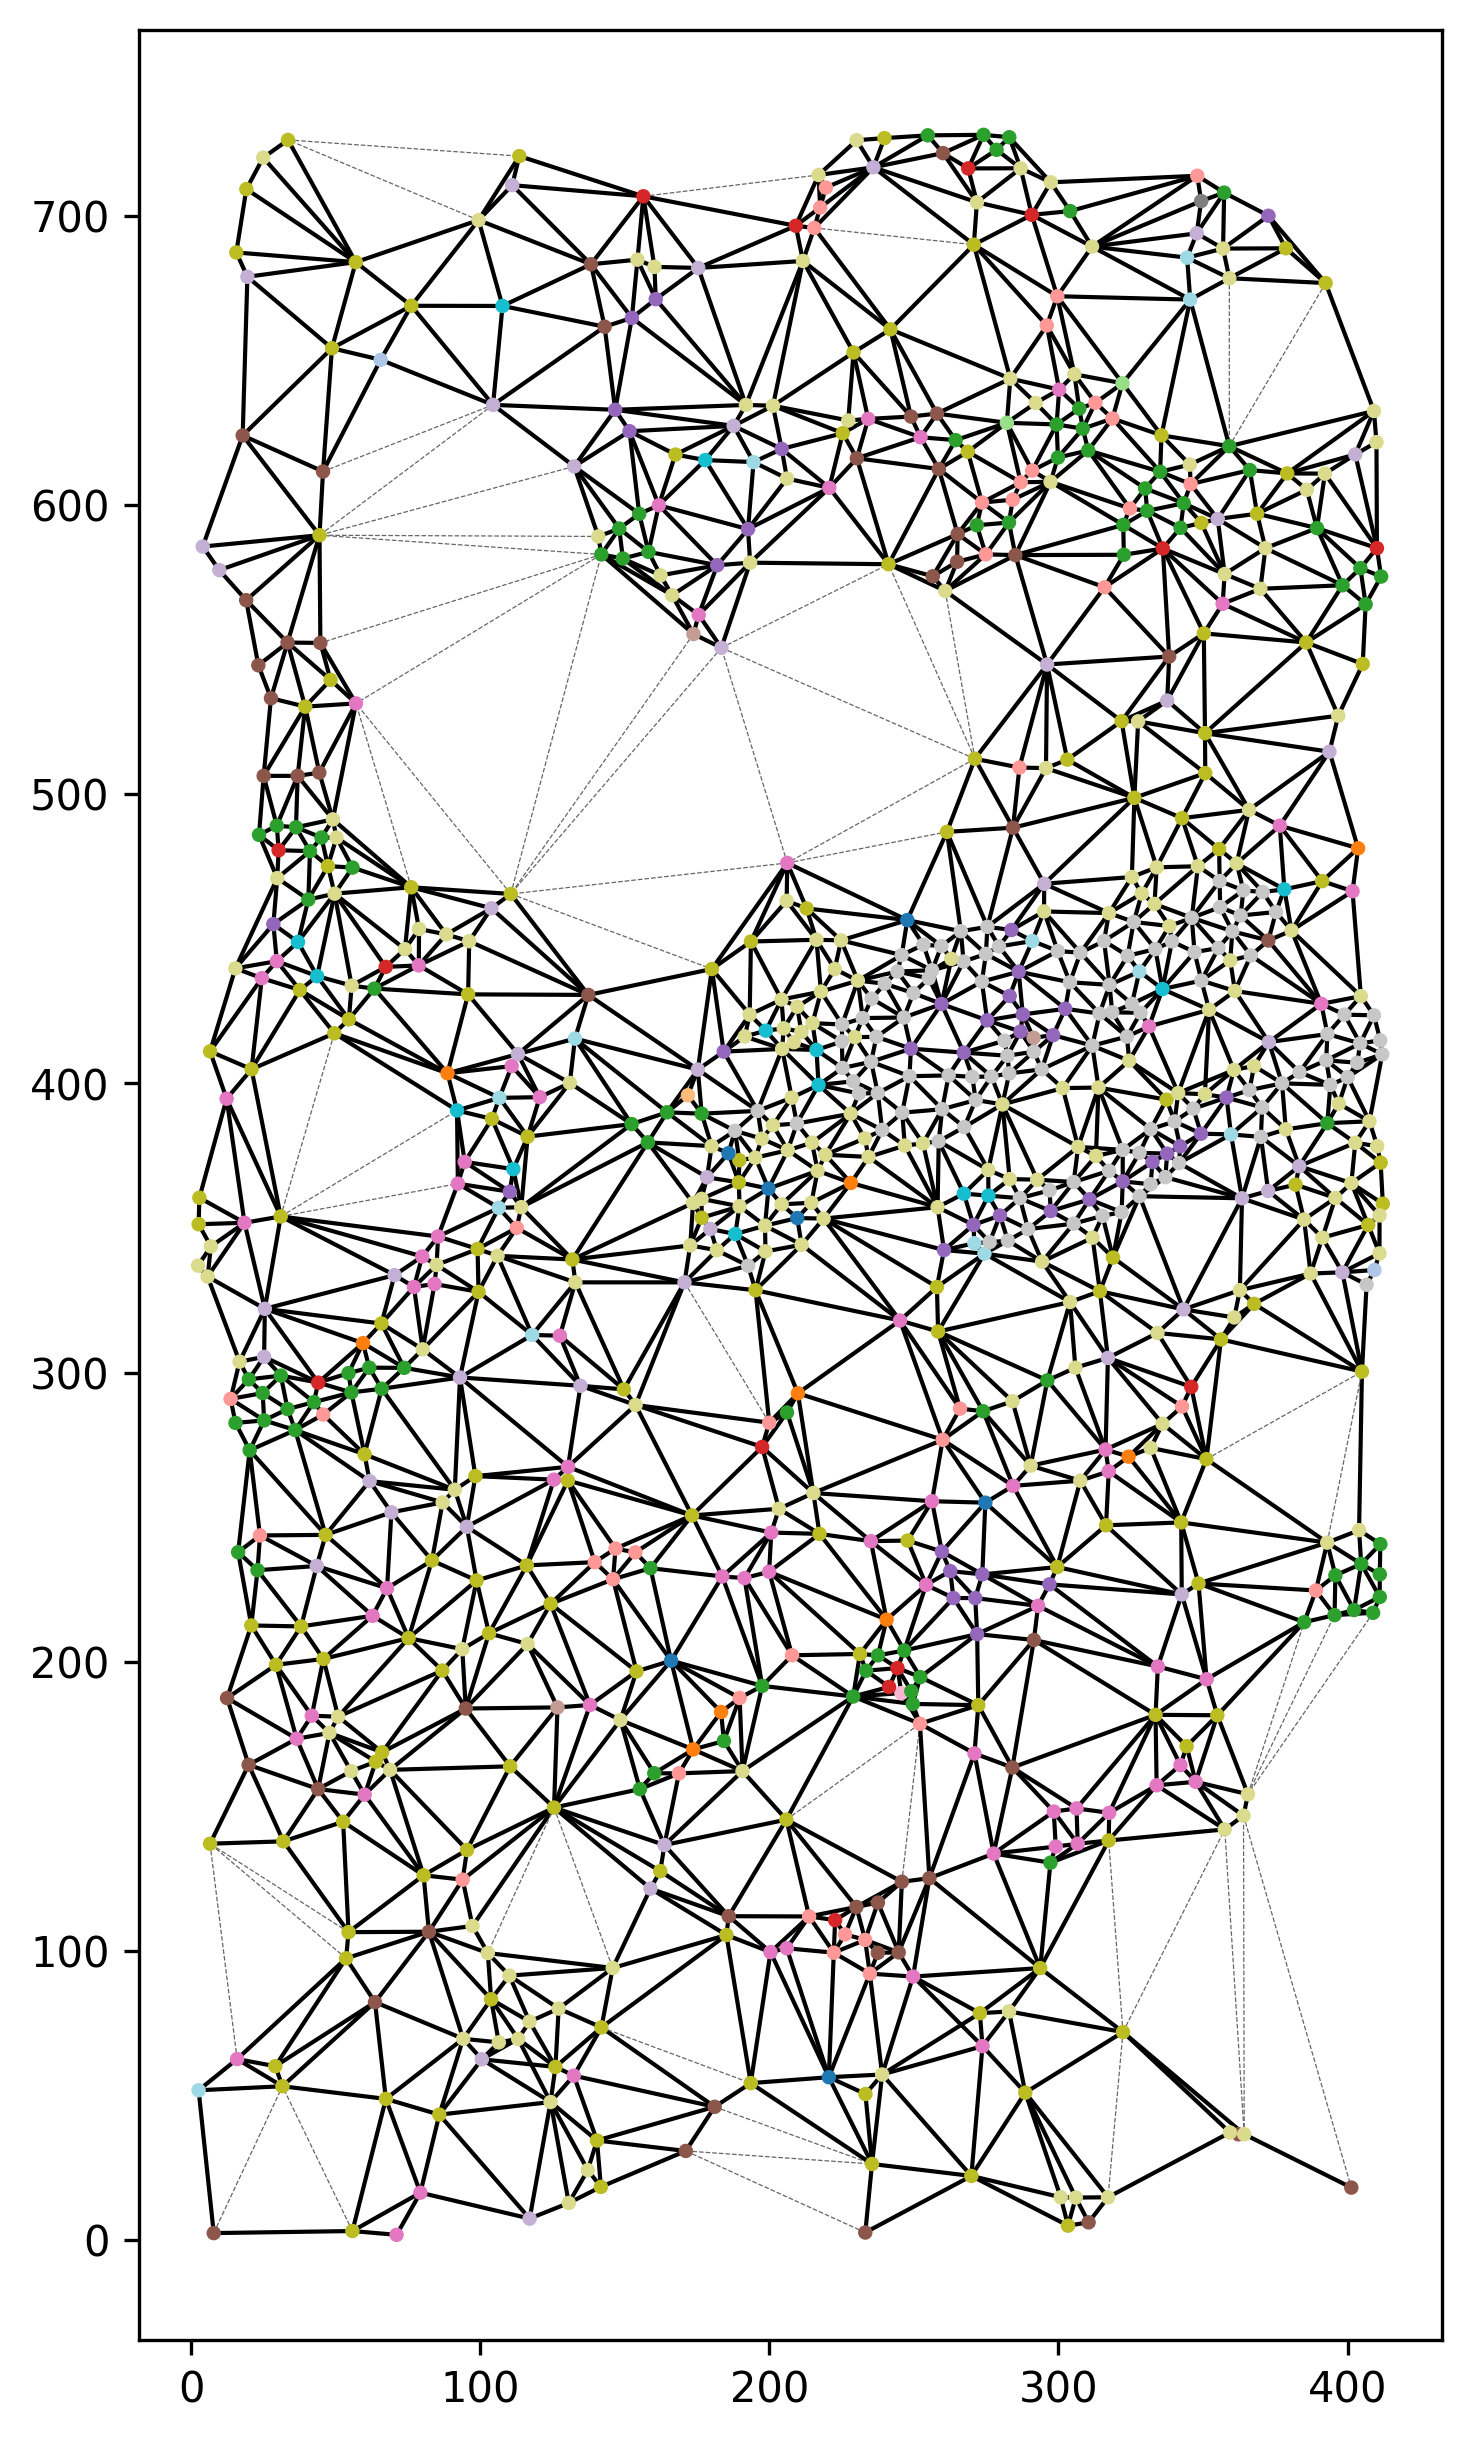

In [16]:
from IPython.display import Image 
pil_img = Image(filename=graph_img_output)
display(pil_img)

<br/><br/><br/><br/>

------------
### Step 2: Construct `CellularGraphDataset`

`CellularGraphDataset` will be the major data container used in model training and evaluation. This object also handles all the featurization, subgraph sampling, and other necessary functionalities for SPACE-GM.

We previously saved all regions as networkx graphs, now we initialize the dataset object using these graph files

In [4]:
dataset_root = "/juno/work/shah/users/ibrahih3/codebase/space-gm/example_data_bodenmiller"
dataset_kwargs = {
    'transform': [],
    'pre_transform': None,
    'raw_folder_name': 'graph',  # os.path.join(dataset_root, "graph") is the folder where we saved nx graphs
    'processed_folder_name': 'tg_graph',  # processed dataset files will be stored here
    'node_features': ["cell_type", "biomarker_expression", "neighborhood_composition", "center_coord"],  # There are all the cellular features that we want the dataset to compute
    'edge_features': ["edge_type", "distance"],  # edge (cell pair) features
    'subgraph_size': 3,  # indicating we want to sample 3-hop subgraphs from these regions (for training/inference), this is a core parameter for SPACE-GM.
    'subgraph_source': 'on-the-fly',
    'subgraph_allow_distant_edge': True,
    'subgraph_radius_limit': 200.,
}

feature_kwargs = {
    "biomarker_expression_process_method": "linear",
    "biomarker_expression_lower_bound": 0,
    "biomarker_expression_upper_bound": 18,
    "neighborhood_size": 10,
}
dataset_kwargs.update(feature_kwargs)

dataset = spacegm.CellularGraphDataset(dataset_root, **dataset_kwargs)

<br/><br/><br/><br/>

The full cellular graph for each region in the dataset can be accessed using the class method `get_full`:

In [5]:
i = 0
dataset.get_full(i)

Data(x=[3558, 59], edge_index=[2, 20942], edge_attr=[20942, 2], num_nodes=3558, region_id='BaselTMA_SP41_100_X15Y5', component_id=0)

<br/><br/><br/><br/>

And the n-hop (n=3 in this example) subgraph of region `i` around its center node `j` can be accessed using the class method `get_subgraph`: 

In [6]:
i = 0
j = 1234
dataset.get_subgraph(i, j)

Data(x=[37, 59], edge_index=[2, 180], edge_attr=[180, 2], center_node_index=18, original_center_node=1234, num_nodes=37, region_id='BaselTMA_SP41_100_X15Y5', component_id=0)

<br/><br/><br/><br/>

By default, indexing the dataset object will yield an n-hop subgraph around a randomly picked center node (see class method `pick_center`) in the specified region:

In [7]:
dataset[0]

Data(x=[38, 59], edge_index=[2, 186], edge_attr=[186, 2], center_node_index=11, original_center_node=1597, num_nodes=38, region_id='BaselTMA_SP41_100_X15Y5', component_id=0)

<br/><br/><br/><br/>

There is also a quick plotting functions for subgraphs: `plot_subgraph`

(-30.073706004140426,
 109.32008281573462,
 90.12919254658448,
 229.52298136645953)

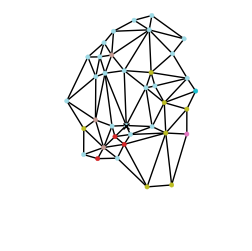

In [8]:
i = 0
j = 1234

plt.figure(figsize=(3, 3))
dataset.plot_subgraph(i, j)
plt.axis('off')

<br/><br/><br/><br/>

During training, due to the high throughput of data streaming, on-the-fly calculation of subgraph might be slow. To speed up data loading, we will save all subgraphs to chunk files first and load them during training/inference.

In [7]:
dataset.save_all_subgraphs_to_chunk()

In [11]:
import time

dataset.clear_cache()
dataset.set_subgraph_source('on-the-fly') # Can also be set through the `subgraph_source` argument
t0 = time.time()
for _ in range(5000):
    d = dataset[0]
t1 = time.time()
print("Sampling 5000 subgraphs on-the-fly took %.2f seconds" % (t1 - t0))

dataset.clear_cache()
dataset.set_subgraph_source('chunk_save')  
t0 = time.time()
for _ in range(5000):
    d = dataset[0]
t1 = time.time()
print("Loading 5000 subgraphs from chunk save took %.2f seconds" % (t1 - t0))


Sampling 5000 subgraphs on-the-fly took 14.57 seconds
Loading 5000 subgraphs from chunk save took 7.83 seconds


<br/><br/><br/><br/>

Transformers will be used to mask features, add node-level and graph-level tasks, etc.

In [9]:
transformers = [
    # `AddCenterCellType` will add `node_y` attribute to the subgraph for node-level prediction task
    # In this task we will mask the cell type of the center cell and use its neighborhood to predict the true cell type
    spacegm.AddCenterCellType(dataset),
    # `AddGraphLabel` will add `graph_y` and `graph_w` attributes to the subgraph for graph-level prediction task
    spacegm.AddGraphLabel(graph_label_file, tasks=['ERStatus', 'PRStatus', 'HER2Status']),
    # Transformer `FeatureMask` will zero mask all feature items not included in its argument
    # In this tutorial we perform training/inference using cell types and center cell's size feature
    spacegm.FeatureMask(dataset, use_center_node_features=['cell_type'], use_neighbor_node_features=['cell_type']),
]

dataset.set_transforms([])  # No transformation
d1 = dataset[0]

dataset.set_transforms(transformers)
d2 = dataset[0]

<br/><br/>
`d1.x` has a full feature matrix, while `d2.x` only has the first column (for cell types) populated, except for its center cell, which has an additional feature of size.

(`d1` and `d2` are different subgraphs due to the random sampling)

In [10]:
print("\nFeatures of `d1`")
display(d1.x)
print("\nFeatures of `d2`")
display(d2.x)
print("\nCenter cell feature of `d2`")
display(d2.x[d2.center_node_index])


Features of `d1`


tensor([[1.6000e+01, 6.5983e-03, 1.3225e-02,  ..., 0.0000e+00, 1.4629e+02,
         7.1058e+02],
        [1.1000e+01, 7.6729e-03, 2.6046e-02,  ..., 0.0000e+00, 1.5528e+02,
         7.0766e+02],
        [4.0000e+00, 5.4605e-03, 3.3624e-02,  ..., 0.0000e+00, 1.4770e+02,
         7.0137e+02],
        ...,
        [4.0000e+00, 6.3707e-03, 4.3337e-02,  ..., 0.0000e+00, 1.9766e+02,
         7.1550e+02],
        [4.0000e+00, 1.0210e-02, 4.4707e-02,  ..., 0.0000e+00, 1.9072e+02,
         7.0807e+02],
        [4.0000e+00, 7.8708e-03, 2.3106e-02,  ..., 0.0000e+00, 1.9440e+02,
         6.8612e+02]], dtype=torch.float64)


Features of `d2`


tensor([[21.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 4.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 4.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [16.,  0.,  0.,  ...,  0.,  0.,  0.],
        [22.,  0.,  0.,  ...,  0.,  0.,  0.],
        [18.,  0.,  0.,  ...,  0.,  0.,  0.]], dtype=torch.float64)


Center cell feature of `d2`


tensor([4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], dtype=torch.float64)

<br/><br/>

Note that d2 has additional attributes: `d2.node_y`, `d2.graph_y`, `d2.graph_w`

In [11]:
display(d1)
display(d2)

Data(x=[26, 59], edge_index=[2, 122], edge_attr=[122, 2], center_node_index=4, original_center_node=1572, num_nodes=26, region_id='BaselTMA_SP41_100_X15Y5', component_id=0)

Data(x=[40, 59], edge_index=[2, 196], edge_attr=[196, 2], center_node_index=21, original_center_node=1614, num_nodes=40, region_id='BaselTMA_SP41_100_X15Y5', component_id=0, node_y=[1], graph_y=[1, 3], graph_w=[1, 3])

<br/><br/><br/><br/>

------

### Step 3 Initialize a Graph Neural Network (GNN)

Now we construct a graph neural network for predicting `survival_status`.

The graph neural network will be composed of 3 parts:
1. The backbone GNN with specified number of graph convolutional layers
2. A node task prediction module if there are node-level tasks defined, this module will be constructed based on the node embedding of the center node
3. A graph task prediction module if there are graph-level tasks defined, this module will be constructed based on the graph-pooled embedding of all the nodes

In [19]:
len(dataset.cell_type_mapping) + 1

27

In [12]:
model_kwargs = {
    'num_layer': dataset.subgraph_size,  # same number of layers as number of hops in the subgraphs
    'num_node_type': len(dataset.cell_type_mapping) + 1,  # number of embeddings for different cell types (plus one placeholder cell type)
    'num_feat': dataset[0].x.shape[1] - 1,  # exclude the cell type column
    'emb_dim': 512, 
    'num_node_tasks': len(dataset.cell_type_mapping),  # A multi-class classification task: predicting center cell type
    'num_graph_tasks': 3,  # a binary classification task
    'node_embedding_output': 'last', 
    'drop_ratio': 0.25, 
    'graph_pooling': "max", 
    'gnn_type': 'gin',
}

model = spacegm.GNN_pred(**model_kwargs)
device = 'cpu'

display(model)

GNN_pred(
  (gnn): GNN(
    (x_embedding): Embedding(27, 512)
    (feat_embedding): Linear(in_features=58, out_features=512, bias=True)
    (gnns): ModuleList(
      (0-2): 3 x GINConv()
    )
    (batch_norms): ModuleList(
      (0-2): 3 x BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (graph_pred_module): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=3, bias=True)
  )
  (node_pred_module): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=26, bias=True)
  )
)

<br/><br/><br/><br/>

------

### Step 4 Train the GNN

GNNs in SPACE-GM are trained using n-hop subgraphs, see `data.SubgraphSampler` for details.

In this tutorial we specified one node-level task (predicting center cell type) and one graph-level task (predicting binary survival status), each task will have a specific loss function.


In [18]:
train_kwargs = {
    'batch_size': 64,
    'lr': 0.001,
    'graph_loss_weight': 1.0,  # Weight of graph task loss relative to node task loss
    'num_iterations': 50,  # In this demo we only train for 50 iterations/batches

    # Loss functions
    'node_task_loss_fn': nn.CrossEntropyLoss(),
    'graph_task_loss_fn': spacegm.models.BinaryCrossEntropy(),    

    # Evaluation during training
    'evaluate_fn': [spacegm.train.evaluate_by_sampling_subgraphs, spacegm.train.evaluate_by_full_graph, spacegm.train.save_model_weight],
    'evaluate_freq': 10,  # Evaluate the model every 10 iterations
}

<br/><br/>

On-the-fly evaluation of model performances is included in the training pipeline:

In [21]:
evaluate_kwargs = {
    'node_task_evaluate_fn': spacegm.inference.cell_type_prediction_evaluate_fn,
    'graph_task_evaluate_fn': spacegm.inference.graph_classification_evaluate_fn,
    'full_graph_node_task_evaluate_fn': spacegm.inference.full_graph_cell_type_prediction_evaluate_fn,
    'full_graph_graph_task_evaluate_fn': spacegm.inference.full_graph_graph_classification_evaluate_fn,
    'num_eval_iterations': 10,
    'score_file': os.path.join(model_save_root, 'GIN-example.txt'),
    'model_folder': os.path.join(model_save_root, 'GIN-example'),
}
train_kwargs.update(evaluate_kwargs)

<br/><br/>

Run training:

In [22]:
model = spacegm.train.train_subgraph(
    model, 
    dataset,
    device,
    # train_inds=[0, 1, 2, 3],
    # valid_inds=[0, 1, 2, 3],
    **train_kwargs)

Finished iterations 10
Finished iterations 20
Finished iterations 30
Finished iterations 40


<br/><br/>

Evaluation metrics during training are saved in the specified score file:

In [23]:
with open(evaluate_kwargs['score_file'], 'r') as f:
    for line in f.readlines():
        print(line)

Eval-Subgraph,Train,node-score,0.086,0.109,0.228,0.367,graph-score,0.765,0.671,0.663

Eval-Full-Graph,Train,node-score,0.083,0.091,0.277,0.369,graph-score,0.858,0.746,0.711

Eval-Subgraph,Train,node-score,0.190,0.286,0.469,0.553,graph-score,0.769,0.704,0.681

Eval-Full-Graph,Train,node-score,0.186,0.296,0.484,0.566,graph-score,0.837,0.757,0.744

Eval-Subgraph,Train,node-score,0.181,0.234,0.439,0.545,graph-score,0.765,0.654,0.686

Eval-Full-Graph,Train,node-score,0.173,0.208,0.431,0.566,graph-score,0.841,0.705,0.734

Eval-Subgraph,Train,node-score,0.292,0.438,0.648,0.733,graph-score,0.798,0.716,0.725

Eval-Full-Graph,Train,node-score,0.313,0.435,0.640,0.732,graph-score,0.871,0.740,0.747



<br/><br/>

Intermediate model weights are saved in the specified model folder:

In [24]:
print(os.listdir(evaluate_kwargs['model_folder']))

['model_save_0.pt', 'model_save_2.pt', 'model_save_3.pt', 'model_save_1.pt']


<br/><br/><br/><br/>

------

### Step 5 Evaluate the GNN

As GNNs are trained using subgraphs, there are two ways for evaluation (especially for graph-level tasks):

- Sample subgraphs and calculate metrics by treating each subgraph as an independent data point;
- Iterate over all the subgraphs (cells) of each region and calculate metrics, for graph-level tasks treat the aggregated (average) prediction from a region as an independent data point;

This is also reflected in the on-the-fly evaluation above: `spacegm.train.evaluate_by_sampling_subgraphs` and `spacegm.train.evaluate_by_full_graph`.

Here we demonstrate the two types of evaluation:

In [13]:
# Evaluation by iterating over the full graph
node_preds, graph_preds = spacegm.inference.collect_predict_for_all_nodes(
    model, dataset, device, print_progress=True)

# Aggregated (average) predictions of each region
for i, pred in graph_preds.items():
    region_id = dataset[i].region_id
    predicted_prob = 1 / (1 + np.exp(-np.array(pred)))  # Sigmoid
    avg_pred = np.mean(predicted_prob)
    print("On region %s, average prediction: %.3f" % (region_id, avg_pred))

spacegm.inference.full_graph_graph_classification_evaluate_fn(dataset, graph_preds, print_res=True)

redict on 90
predict on 91
predict on 92
predict on 93
predict on 94
predict on 95
predict on 96
predict on 97
predict on 98
predict on 99
predict on 100
predict on 101
predict on 102
predict on 103
predict on 104
predict on 105
predict on 106
predict on 107
predict on 108
predict on 109
predict on 110
predict on 111
predict on 112
predict on 113
predict on 114
predict on 115
predict on 116
predict on 117
predict on 118
predict on 119
predict on 120
predict on 121
predict on 122
predict on 123
predict on 124
predict on 125
predict on 126
predict on 127
predict on 128
predict on 129
predict on 130
predict on 131
predict on 132
predict on 133
predict on 134
predict on 135
predict on 136
predict on 137
predict on 138
predict on 139
predict on 140
predict on 141
predict on 142
predict on 143
predict on 144
predict on 145
predict on 146
predict on 147
predict on 148
predict on 149
predict on 150
predict on 151
predict on 152
predict on 153
predict on 154
predict on 155
predict on 156
predic

[0.5577395577395577, 0.4979240506329114, 0.4969647251845775]

In [16]:
# Evaluation by sampling subgraphs
node_preds, node_labels, graph_preds, graph_ys, graph_ws = spacegm.inference.collect_predict_by_random_sample(
    model, dataset, device, num_eval_iterations=50)
spacegm.inference.graph_classification_evaluate_fn(graph_preds, graph_ys, graph_ws)

GRAPH [0.5522731272483645, 0.5028090021037834, 0.5087674428930189]


[0.5522731272483645, 0.5028090021037834, 0.5087674428930189]